# Demo notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext watermark


import dask
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import ncar_jobqueue
import numpy as np
import pandas as pd
import xarray as xr
import xgcm

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 180

xr.set_options(keep_attrs=True, display_style="html")

%watermark -iv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
numpy        : 1.19.2
distributed  : 2.30.0
matplotlib   : 3.3.2
ncar_jobqueue: 2020.3.4
xarray       : 0.16.3.dev150+g37522e991
xgcm         : 0.5.1.dev91+g86c9641
dask         : 2.30.0
pandas       : 1.1.3



In [2]:
cluster = ncar_jobqueue.NCARCluster(
    project="NCGD0048",
    scheduler_options=dict(dashboard_address=":9797"),
)

cluster.scale(4)

client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.205.200:37558 Dashboard: https://jupyterhub.ucar.edu/dav/user/dcherian/proxy/9797/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Read one year of daily average data

In [12]:
path = "/glade/p/nsc/ncgd0048/ETP_1_20/COMPRESSED_OCEAN_DAILY/*_2005_*"
ds = xr.open_mfdataset(path, parallel=True, chunks={"zl": 20}).isel(time=slice(2,None))  
# the first two timesteps are 2004-12-30 and 2004-12-31 for some reason, exclude those
ds

,Array,Chunk
Bytes,182.95 GB,72.00 MB
Shape,"(363, 140, 900, 1000)","(1, 20, 900, 1000)"
Count,8016 Tasks,2541 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,182.95 GB,72.00 MB
Shape,"(363, 140, 900, 1000)","(1, 20, 900, 1000)"
Count,8016 Tasks,2541 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Plot fields

Calculate a monthly mean

In [28]:
monthly = ds.resample(time="M").mean()

The monthly mean temperature at one depth level is only 46MB. Let's calculate it and save

In [29]:
monthly.thetao.sel(zl=200, method="nearest").nbytes/1e6

43.2

In [49]:
T200 = monthly.thetao.sel(zl=200, method="nearest").load()

### Annual mean $T_{200}$

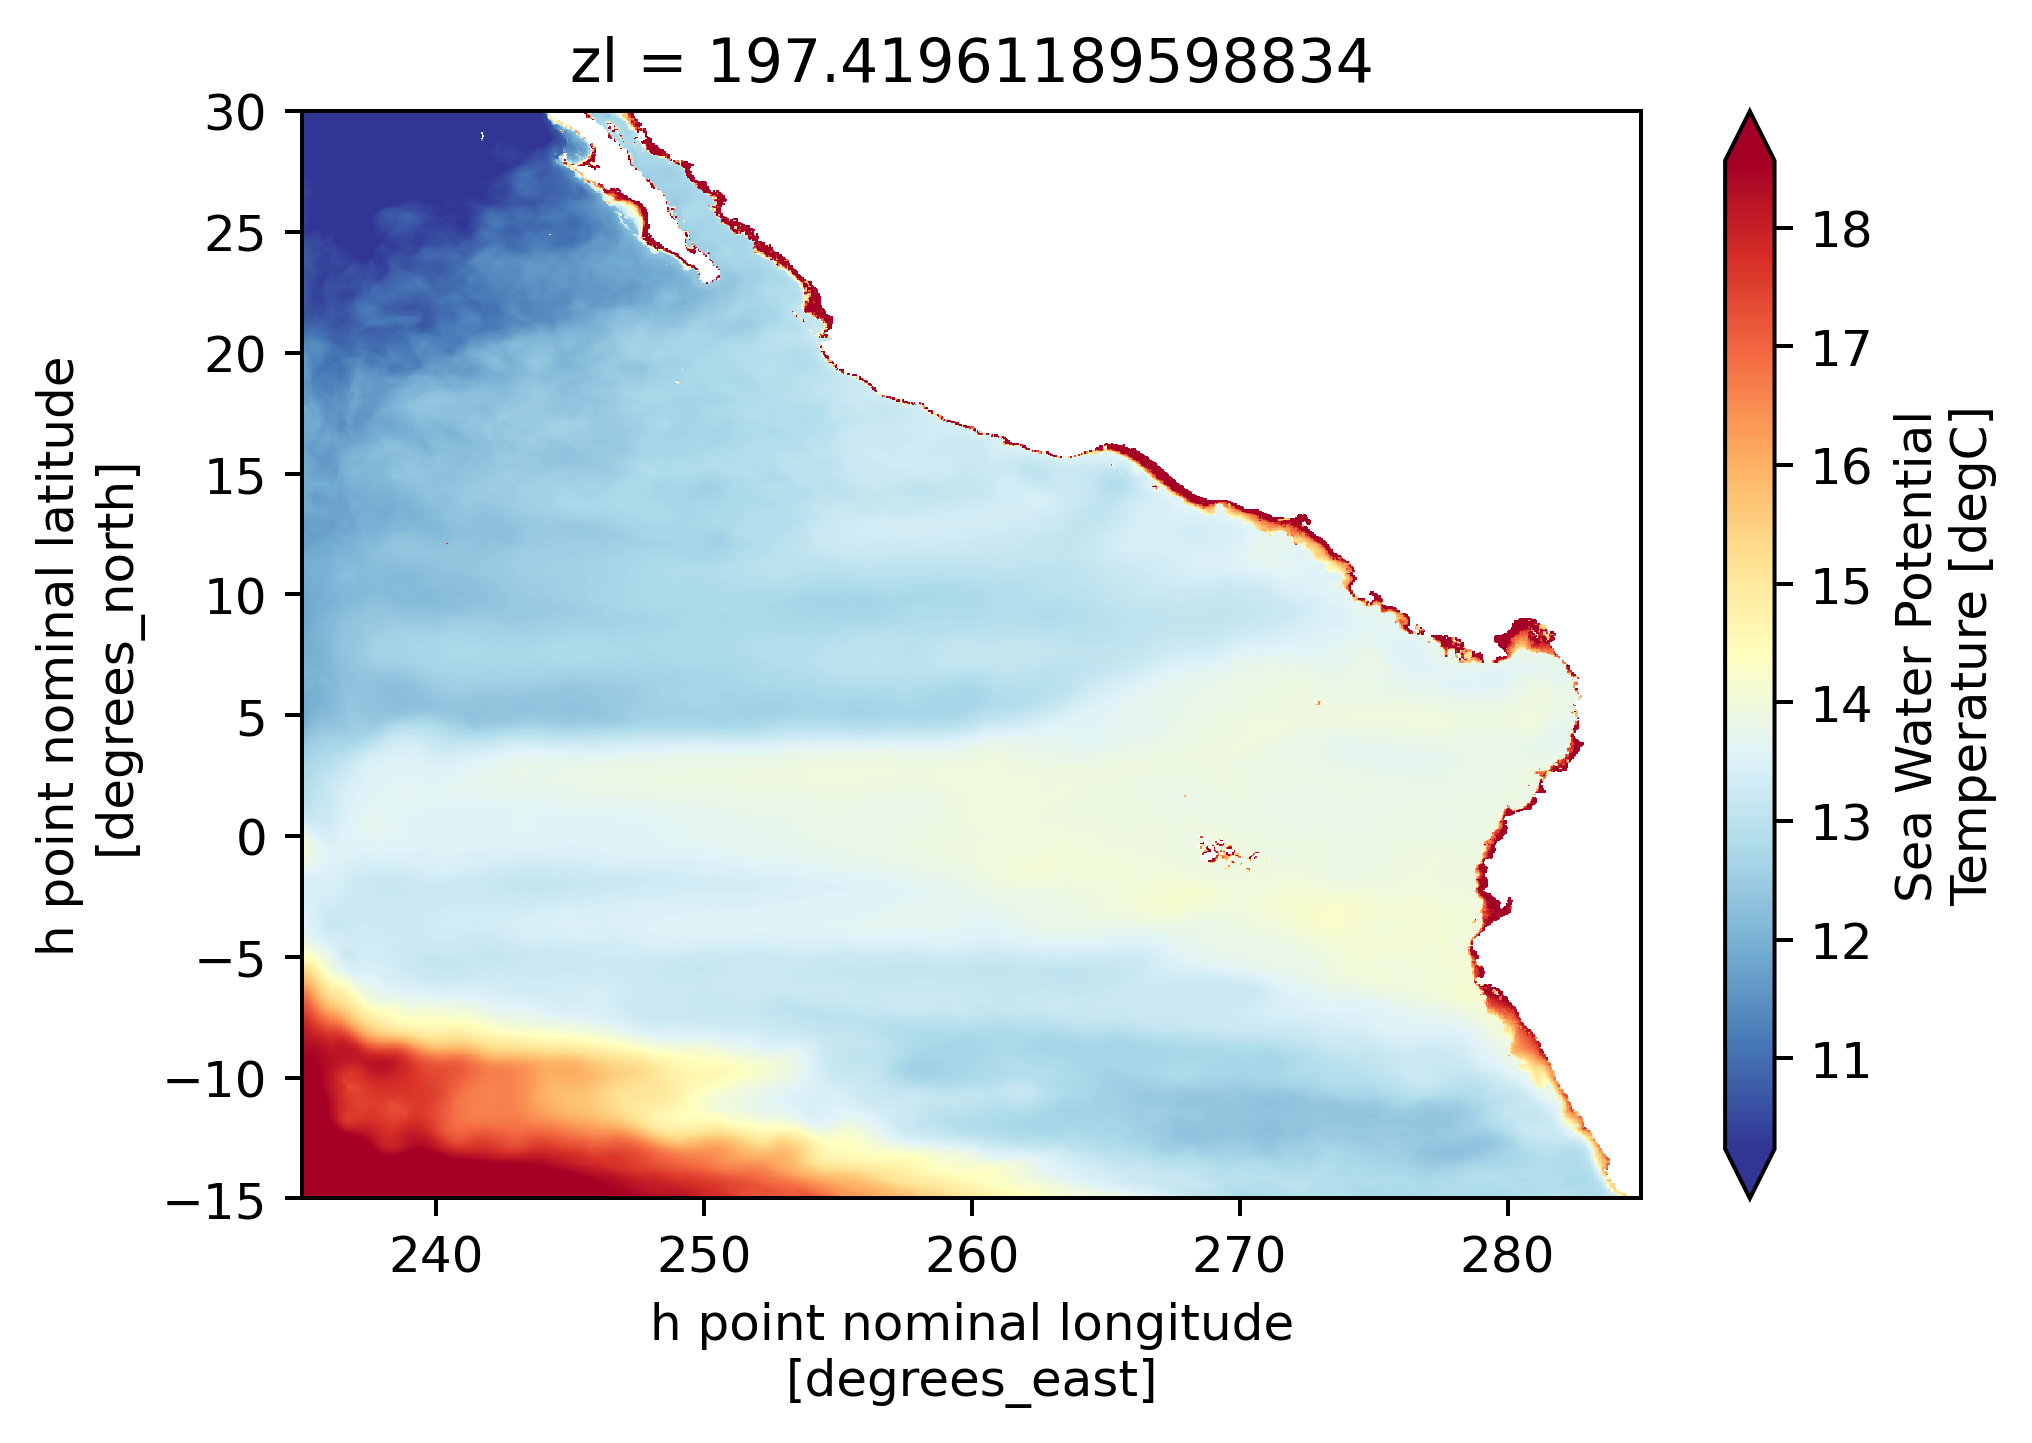

In [54]:
T200.weighted(T200.time.dt.daysinmonth).mean("time").plot(robust=True, cmap=mpl.cm.RdYlBu_r)

### Monthly mean $T_{200}$

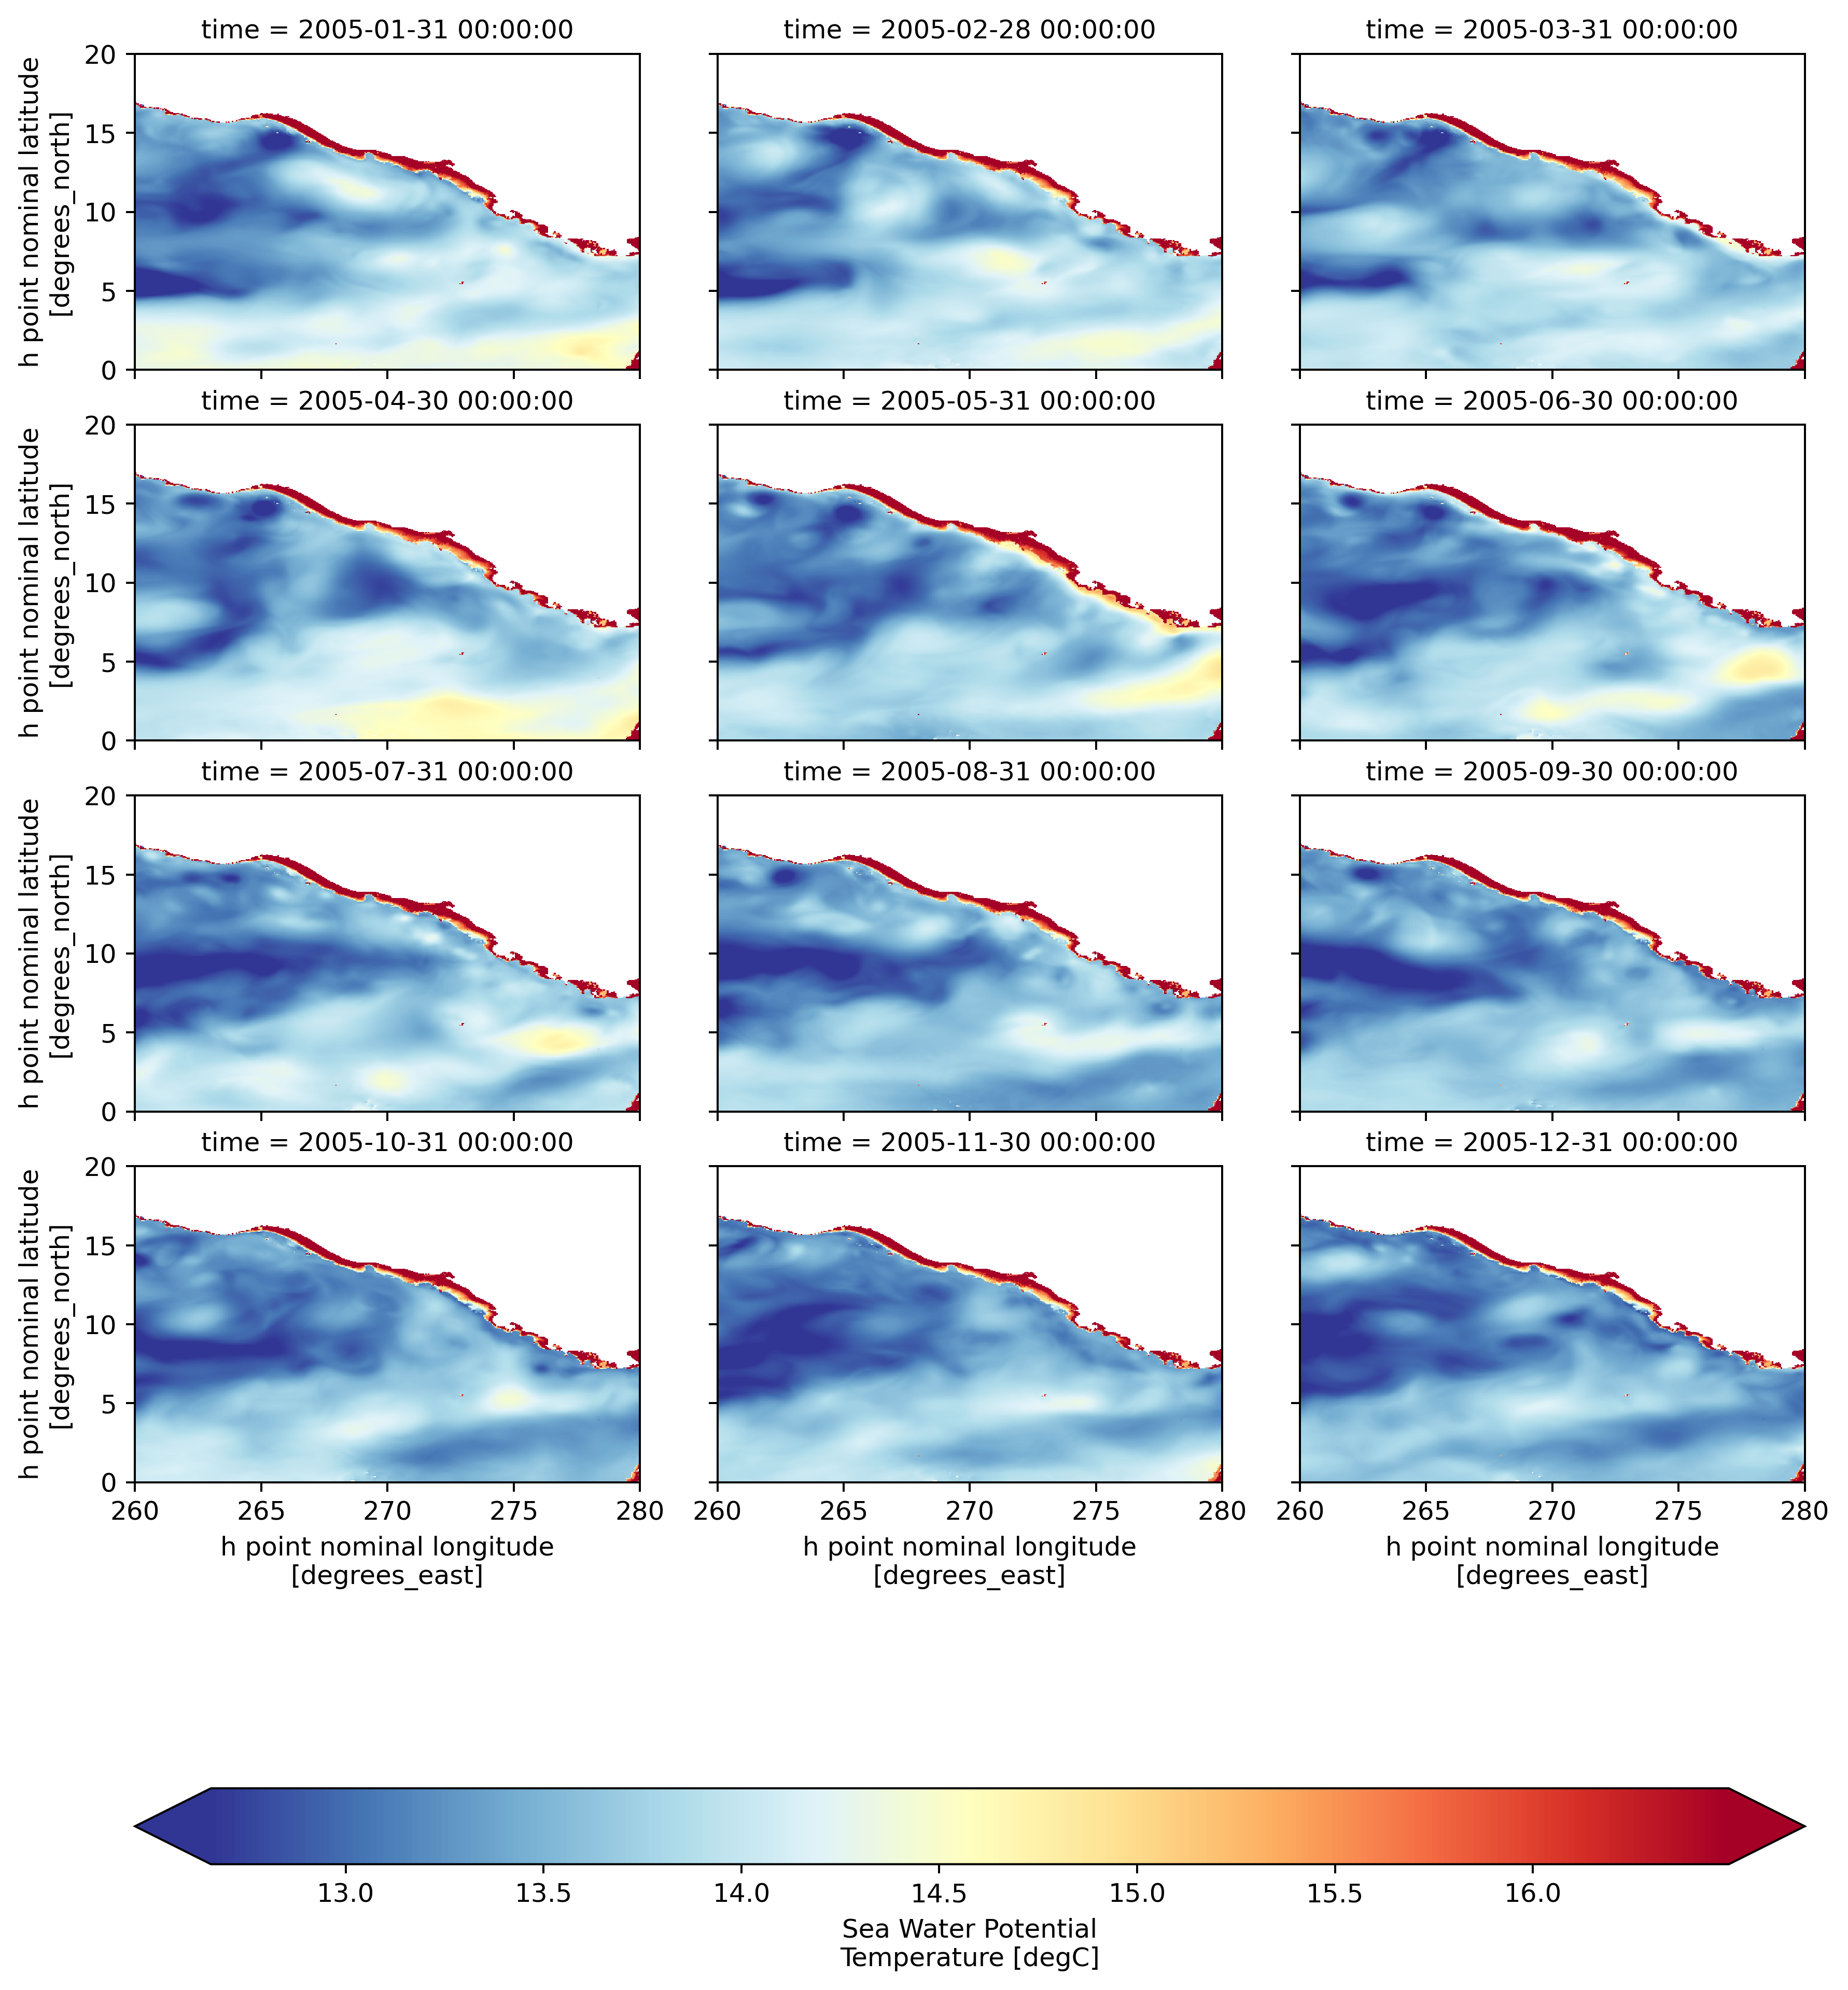

In [55]:
(
    T200
    .sel(xh=slice(260, 280), yh=slice(0, 20))  # subset to (260°E→ 280°E), (0°N-20°N)
    .plot(
        col="time",
        col_wrap=3,
        robust=True,  # 2nd, 98th percentile as colormap limits
        cmap=mpl.cm.RdYlBu_r,  # colormap
        cbar_kwargs={"orientation": "horizontal"},  # horizontal colorbar
    )
)